In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import re
import string
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
    
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Embedding, GRU, LSTM, SimpleRNN, Conv1D, Dense, Dropout, Attention, Bidirectional
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import nltk
nltk.download('stopwords')
log_dir = "logs/"  # Especifique o diretório onde os logs serão armazenados
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gyova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [64]:
df = pd.read_excel('../data/dataset2.xlsx')
df = df.drop(columns=['Titulo', 'Subtitulo', 'Categoria', 'Data', 'Autor', 'URL'])
df.isnull().any()
df = df.dropna()

In [65]:
df['Classe']


0        0.0
1        1.0
2        1.0
3        1.0
4        0.0
        ... 
11898    0.0
11899    1.0
11900    0.0
11901    1.0
11902    0.0
Name: Classe, Length: 11902, dtype: float64

In [66]:
stop_words = set(stopwords.words('portuguese'))

def remover_stop_words(news):
    palavras = news.split()
    palavras_sem_stop = [palavra for palavra in palavras if palavra.lower() not in stop_words]
    return ' '.join(palavras_sem_stop)

def review_cleaning(text):
    
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df["Noticia"] = df["Noticia"].apply(remover_stop_words)
df['Classe'] = df.apply(lambda row: 0 if row.Classe == 1.0 else 1, axis=1)
X = df.drop(['Classe'], axis = 1)
Y = df['Classe']


In [67]:
X_test = df['Noticia'].apply(lambda x: x.lower())
y_test = Y

In [68]:
#variaveis dos modelos
maxlen=256
num_words = 8000
batch_size = 128 
epochs = 20 
validation_fraction = 0.2
output_dim = 64



early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [69]:

text_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>',num_words=num_words)
text_tokenizer.fit_on_texts(X_test.values)
text_word_index = text_tokenizer.word_index
text_sequences = text_tokenizer.texts_to_sequences(X_test)

test_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(text_sequences, maxlen=maxlen)

test_padded_seqeunces = test_padded_seqeunces[:, :, tf.newaxis]

x_test_padded_seqeunces = test_padded_seqeunces[:, :, tf.newaxis]

vectorizer = CountVectorizer(max_features=num_words)
vectorizer.fit(X_test)
X_test = vectorizer.transform(X_test).toarray()

### Teste

In [40]:
with open('../models/MLPClassifierWithGridSearchCV.pkl', 'rb') as arquivo:
    mlpG = pickle.load(arquivo)
    
modelLSTM = load_model('../models/modelLSTM.keras')
model_han = load_model('../models/modelHAN.keras')

Inicio do Teste
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      5951
           1       0.10      0.00      0.00      5951

    accuracy                           0.50     11902
   macro avg       0.30      0.50      0.33     11902
weighted avg       0.30      0.50      0.33     11902

Matriz de confusão


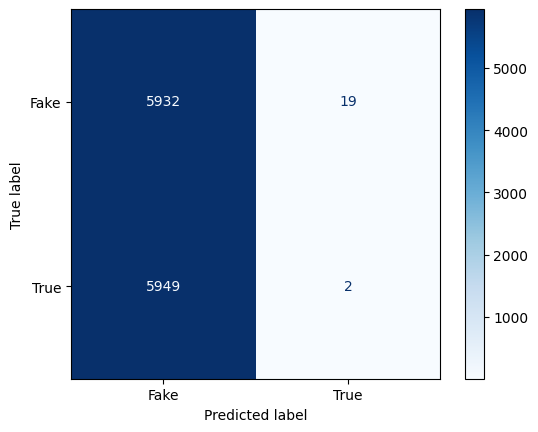

Fim do Teste


In [41]:
print("Inicio do Teste")
y_test_pred = mlpG.predict(X_test)
y_test_pred = (y_test_pred > 0.70)
mlp_acc = round(accuracy_score(y_test, y_test_pred), 2)

cm = confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

print("=" * 20)
print("Matriz de confusão")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True'])
disp.plot(cmap='Blues', values_format='.0f')
plt.savefig('../matriz/confusion_matrix_MLP.png')
plt.show()
print("Fim do Teste")

Inicio do Teste
372/372 [==============================] - 31s 83ms/step
              precision    recall  f1-score   support

           0       0.50      0.98      0.66      5951
           1       0.42      0.01      0.02      5951

    accuracy                           0.50     11902
   macro avg       0.46      0.50      0.34     11902
weighted avg       0.46      0.50      0.34     11902

Matriz de confusão


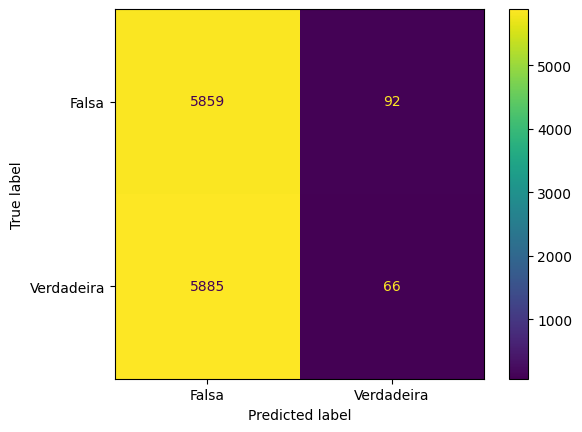

Fim dos testes


In [53]:

print("Inicio do Teste")

y_test_pred = modelLSTM.predict(test_padded_seqeunces)
y_test_pred = (y_test_pred > 0.70)
lstm_acc = round(accuracy_score(y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

print("Matriz de confusão")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Falsa','Verdadeira'], )
disp.plot(values_format='.0f')
plt.show()

print("Fim dos testes")

print("=" * 30)


Inicio do Teste
372/372 [==============================] - 31s 78ms/step
              precision    recall  f1-score   support

           0       0.50      0.97      0.66      5951
           1       0.40      0.02      0.04      5951

    accuracy                           0.49     11902
   macro avg       0.45      0.49      0.35     11902
weighted avg       0.45      0.49      0.35     11902

Matriz de confusão


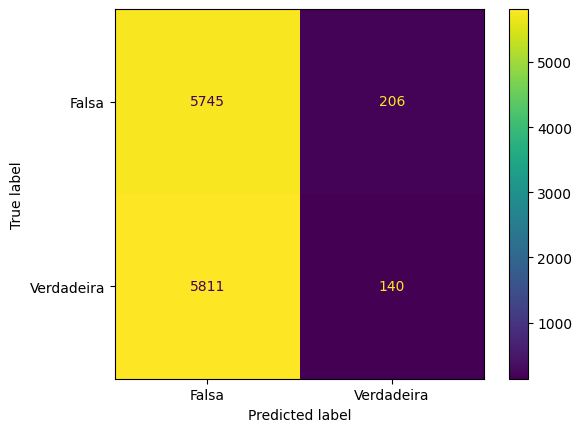

Fim dos testes


In [70]:

print("Inicio do Teste")
y_test_pred = model_han.predict(test_padded_seqeunces)
y_test_pred = (y_test_pred > 0.70)
han_acc = round(accuracy_score(y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

print("Matriz de confusão")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Falsa','Verdadeira'], )
disp.plot(values_format='.0f')
plt.show()

print("Fim dos testes")
